<a class="anchor" id="home"><img src="Images/frangiPANe.png" width=50% align=right></a>

***

# <span style="color: #3987C4;">Table of contents</span>
<a class="anchor" id="home"></a>

[I - What is frangiPANe?](#whatabout)

* [Map-then-assembly approach](#approach)
* [Requirements](#requirements)
* [Data test](#datatest)
* [License](#license)
    
[II - Preparing frangiPANe analysis](#howtoconfigure)
* [Import python packages used by frangiPANe](#importpackages)
* [Definition of input data used by frangiPANe workflow](#configinput)
* [Creating frangiPANe output directory](#outputdir)
* [Creating log file](#logfile)
* [Preparing Genome Reference for next analysis](#reference)
* [Analyzing Group File](#group)
    
[III - Workflow](#workflow)
* [1 - Stats about raw data](#rawdata)
* [2 - Mapping the individuals reads against the reference genome](#mapping)
* [3 - Assembly of the individuals' reads that do not map (properly paired) on the reference genome](#assembly)
* [4 - Removing Contamination](#contamination)
* [5 - Reducing Sequence Redundancy](#redundancy)
* [6 - Anchoring Clusters on reference genome](#anchoring)

***

[<img src="Images/up-arrow.png" alt="Top" width=2% align="right">](#home "Go back to the top")

# <span style="color: #3987C4;"> I - What is frangiPANe ?  <a class="anchor" id="whatabout"></a></span>

This tool allows the generation of a linear panreference, from paired-end short-reads and a reference genome using a Map-Then-Assembly approach.

<img src="Images/frangiPANe_overview.jpg" width=70%>

### <span style="color: #919395"> _Map-then-assembly approach_ <a class="anchor" id="approach"></a></span>

<img src="Images/approachMapThenAssembly.jpg" width=80%>

### <span style="color: #919395"> _Data test_ <a class="anchor" id="datatest"></a></span>

<details>


#### __Rice__ 

##### _Illumina sequenced dataset_

3 African Rice whole-genome sequences (Cubry and al., 2018) were used (paired-end illumina, 2x101bp, ~35X) :

* AA, _O. barthii_ (African Rice wild)
* AB, _O. barthii_ (African Rice wild)
* DT, _O. glaberrima_ (African Rice cultivated)

><sub><sup>Cubry P, Tranchant-Dubreuil C, Thuillet AC, Monat C, Ndjiondjop MN, Labadie K, Cruaud C, Engelen S, Scarcelli N, Rhoné B, Burgarella C, Dupuy C, Larmande P, Wincker P, François O, Sabot F, Vigouroux Y. The Rise and Fall of African Rice Cultivation Revealed by Analysis of 246 New Genomes. Curr Biol. 2018 Jul 23;28(14):2274-2282.e6. doi: 10.1016/j.cub.2018.05.066. Epub 2018 Jul 5. PMID: 29983312.</sub></sup>

##### _Genome Reference_

_Oryza glaberrima_ (OMAPv2 sequence, ref)

</details>

### <span style="color: #919395">_Requirements_ <a class="anchor" id="requirements"></a></span>

<details>

* python version

* Python modules used
    * os, io, subprocess
    * Ipython
    * ipywidgets
    * trailets
    * tkinter
    * numpy, pandas
    * matplotlib
    * seaborn
    * panel
    
* Bioinformatics software (version)
    * ea-utils (fastq-stats [doc] (https://expressionanalysis.github.io/ea-utils/)] : Command-line tools for processing biological sequencing data. 
    * BWA [[doc](http://bio-bwa.sourceforge.net/bwa.shtml), [github](https://github.com/lh3/bwa)] : software package for mapping DNA sequences against a large reference genome
    * Samtools [[doc](http://www.htslib.org/doc/samtools.html)] : suite of programs for interacting with high-throughput sequencing data : http://www.htslib.org/download/
    * ABySS [[github](https://github.com/bcgsc/abyss)] : de novo sequence assembler intended for short paired-end reads and large genomes
    * assembly-stats [[github](https://github.com/sanger-pathogens/assembly-stats)] 
    * cd_hit [[github](https://github.com/weizhongli/cdhit/blob/master/doc/cdhit-user-guide.wiki)]

</details>

### <span style="color: #919395">_License_ <a class="anchor" id="license"></a></span>

* Licencied under CeCill-C (http://www.cecill.info/licences/Licence_CeCILL-C_V1-en.html) and GPLv3
* Intellectual property belongs to IRD, ... and SouthGreen development platform
* Written by Clothilde Chenal and Christine Tranchant-Dubreuil
* Copyright 2021

from IPython.display import Javascript
Javascript("Jupyter.notebook.execute_cells([2])")nts/These/frangiPANeGIT/ricents/These/frangiPANeGIT/ricents/These/frangiPANeGIT/rice***

[<img src="Images/up-arrow.png" alt="Top" width=2% align="right">](#home "Go back to the top")

# <span style="color: #3987C4;">II - Preparing frangiPANe analysis <a class="anchor" id="howtoconfigure"></a></span>

### <span style="color: #919395"> _Import python packages used by frangiPANe_ </span>

In [1]:
from tools.jupyter import *
from tools.frangiPANe import *

import panel as pn

pn.extension()

add_css()

file_saved="frangiPANe.p"
text = "Import all python packages required successfully"
output_dir = None
output_mapping_dir = None
total_genome_size= None
k = None
display_alert(text,"success")
bgc('LightBlue')

Alert(str, alert_type='success', css_classes=['alert', 'alert-success']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

project_name, out_dir, ref_file, group_file, fastq_dir= box_config()
bgc('LightBlue')### <span style="color: #919395"> _Definition of input data used by frangiPANe workflow_  <a class="anchor" id="configinput"></a></span>

<details>

* __Project Name__ : the directory name that will contain all the results generated by this analysis
* __Output Directory__ : the parent directory that will contain the __project_name__ directory
* __Fastq Directory__ : the directory that contains .fastq files of all the individuals
* __Reference File__ : the reference genome used to map all reads (fastq files). The reference genome have to be provided in a fasta format. The reference genome must be indexed by BWA for subsequent analyzes. The **REF**.amb, **REF**.ann, **REF**.bwt, **REF**.pac and **REF**.sa files are created.)
* __Group File__ :  (It is common for several individuals to have different origins when building a pangenome. To exploit this diversity in the results, PANtoum needs a tabulated file (separator = tabulation, no header); the first column corresponds to the name of the individuals (should correspond to .fastq files) and the second to the group they belong. NB : It is possible to use only one group.)

ex of samples with 2 groups : wild or cultivated
    
| sample  | group  |
|---|---|
| AA | wild | 
| AB  | wild | 
| CB  | cultivated |

</details>

Run the following cell and fill the parameters box

In [2]:
project_name, out_dir, ref_file, vec_file, group_file, fastq_dir,cpus = box_config()
bgc('LightBlue')

WidgetBox(background='#E3ECF1')
    [0] Markdown(str)
    [1] Column(width=800)
        [0] Row
            [0] TextInput(name='Project name :', placeholder='Enter the name here...')
            [1] TextInput(name='Output directory :', placeholder='Enter the directory p...)
        [1] TextInput(name='Fastq directory', placeholder='Enter the directory p...)
        [2] TextInput(name='Group file', placeholder='Enter the file p...)
        [3] TextInput(name='Reference file', placeholder='Enter the file p...)
        [4] TextInput(name='Univec file', placeholder='Enter the file p...)
        [5] IntSlider(end=36, name='CPU number', start=1, value=6)
        [6] Row
            [0] Button(button_type='primary', name='SAVE', width=100)
            [1] Button(button_type='primary', name='LOAD', width=100)
            [2] Button(button_type='primary', name='INIT', width=100)
        [7] Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], height=200, margin=(0, 0, 25, 0), sizing_mode='stretch_width')

### <span style="color: #919395">_Creating frangiPANe output directory_<a class="anchor" id="outputdirectory"></a></span>

<img src="Images/frangiPANe_output_tree.jpg">

Be careful : if the directory already exists, files and directory that were generated by previous analysis could be removed by new analysis steps

In the log file,  all outputs generated by bioinformatics tools (eg: bwa index, mem, abyss) are saved

In [3]:
if not out_dir.value:
    text = "Fill the form in the previous cell !"
    display_alert(text,"danger")
else:
    cpu = cpus.value
    output_dir = out_dir.value + "/frangiPANe_" + project_name.value
    make_dir(output_dir)
    logger = init_log(output_dir,project_name.value)
    df_group = None
    bgc('LightBlue')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='success', css_classes=['alert', 'alert-success']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

### <span style="color: #919395">_Preparing Genome Reference for next analysis_

#### __Genome indexation__ and __Genome dashboard__

This step is done with `bwa index` if index are absent. Indexation is required before performing reads mapping against genome reference.

Alert(str, alert_type='info', css_classes=['alert', 'alert-info'], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Column(background='WhiteSmoke', sizing_mode='stretch_both')
    [0] Markdown(str)
    [1] Markdown(str)
    [2] Row
        [0] Matplotlib(Figure)
        [1] DataFrame(DataFrame)
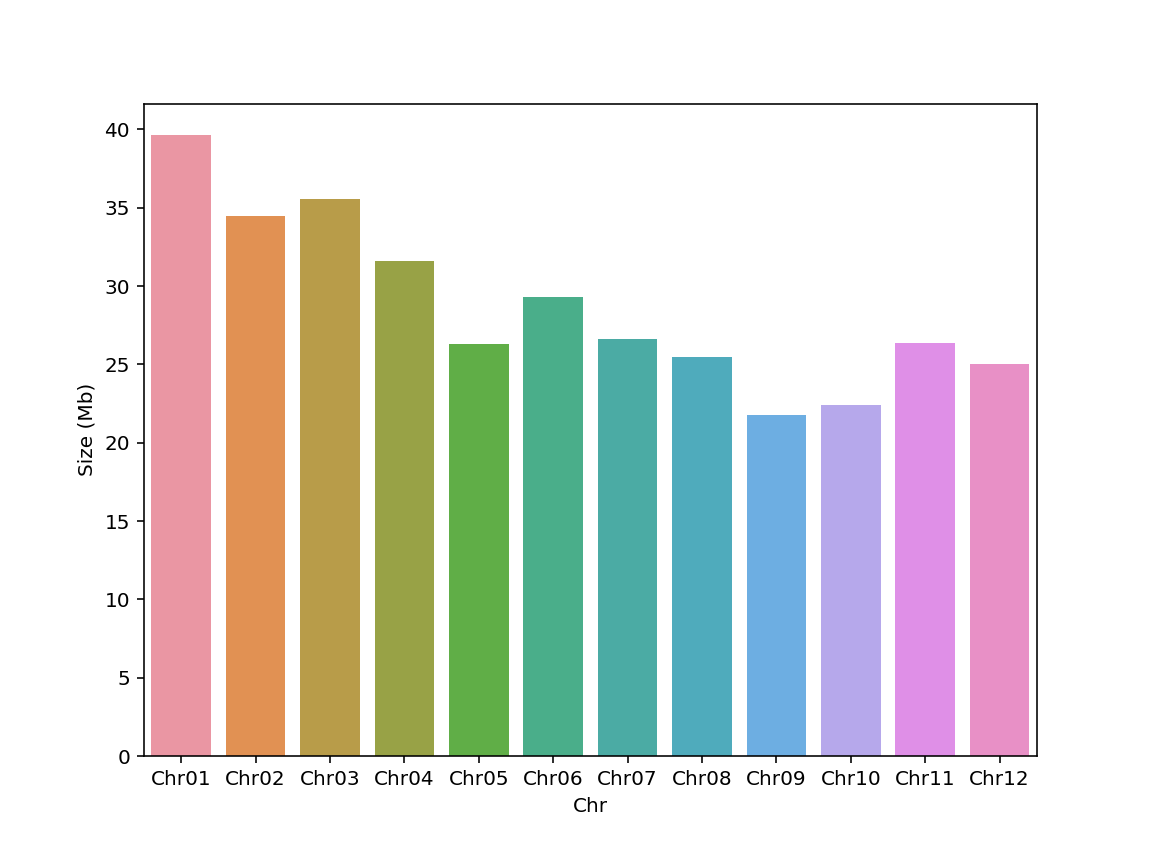

In [4]:
if not ref_file.value:
    text = "Fill the form with the reference file in the previous cell !"
    display_alert(text,"danger")
elif not output_dir:
    text = "Creating frangiPANe output directory is required to continue !"
    display_alert(text,"danger")
else:
    index_reference_genome(ref_file.value, logger)
    total_genome_size=dashboard_genome(ref_file.value)
    bgc('LightBlue')

### <span style="color: #919395">_Analyzing Group File_</span> 

Alert(str, alert_type='success', css_classes=['alert', 'alert-success']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')


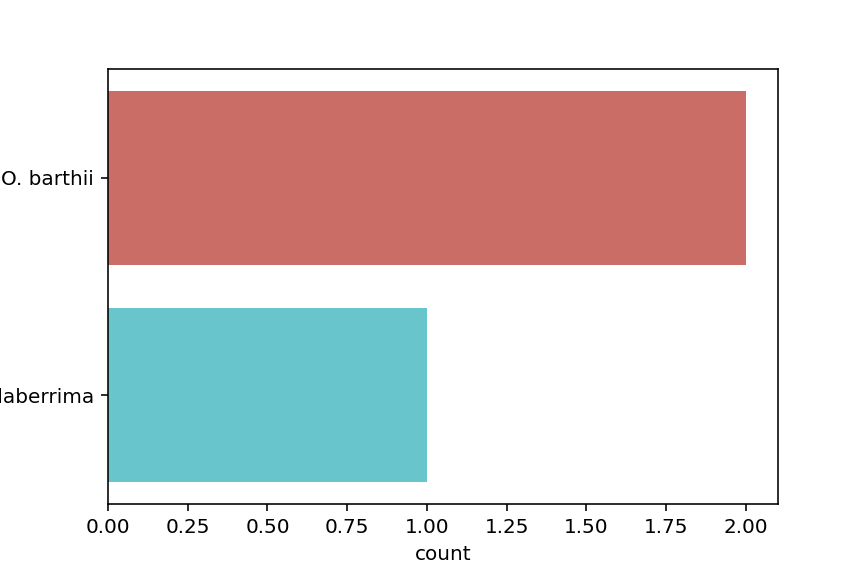

In [5]:
if not group_file.value:
    text = "Fill the form with the group file in the previous cell !"
    display_alert(text,"danger")
elif not output_dir:
    text = "Creating frangiPANe output directory is required to continue !"
    display_alert(text,"danger")
else:
    # Reading group file
    id_dict, df_group = read_group_file(group_file.value,logger)
    # Group file dashboard
    dashboard_group(df_group)
    bgc('LightBlue')

***

[<img src="Images/up-arrow.png" alt="Top" width=2% align="right">](#home "Go back to the top")


# <span style="color: #3987C4;">III - frangiPANe Workflow <a class="anchor" id="workflow"></a></span>

<img src="Images/approachMapThenAssembly.jpg" width=60%>



Only fastq files corresponding to samples described in the group file (contained in fastq directory) will be used in this workflow.

Fastq naming convention: 
* sample_code_1.fastq, sample_code_R1.fastq
* sample_code_1.fq, sample_code_R1.fq
* sample_code_2.fastq, sample_code_R2.fastq
* sample_code_2.fq, sample_code_R2.fq

with sample_code read from the group file (1st column)

### <span style="color: #919395"> _1 - Stats about raw data (fastq files)_

#### __Generating fastq statistics with `fastq_stats`__

After this stat analysis, several files have been created and saved into 00_fastq_stats directory :
* one file (fastq-stat) by fastq file
* one file with all stats : all_fastq-stats.csv

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='info', css_classes=['alert', 'alert-info'], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='info', css_classes=['alert', 'alert-info'], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='success', css_classes=['alert', 'alert-success']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Column(background='WhiteSmoke', sizing_mode='stretch_both', width=800)
    [0] Markdown(str)
    [1] Row(width=800)
        [0] Markdown(str)
        [1] Spacer(sizing_mode='stretch_both', width=100)
        [2] Markdown(str)
    [2] Row(width=800)
        [0] Markdown(str)
        [1] Spacer(sizing_mode='stretch_both', width=100)
        [2] Matplotlib(Figure)
    [3] Row(width=800)
        [0] Markdown(str)
        [1] Spacer(sizing_mode='stretch_both', width=100)
        [2] Matplotlib(Figure)
    [4] Row(width=800)
        [0] Markdown(str)
        [1] Spacer(sizing_mode='stretch_both', width=100)
        [2] Matplotlib(Figure)
    [5] Row(width=800)
        [0] Markdown(str)
        [1] Spacer(sizing_mode='stretch_both', width=100)
        [2] Matplotlib(Figure)
    [6] Row(width=800)
        [0] Markdown(str)
        [1] Spacer(sizing_mode='stretch_both', width=100)
        [2] Matplotlib(Figure)
    [7] DataFrame(DataFrame, width=800)
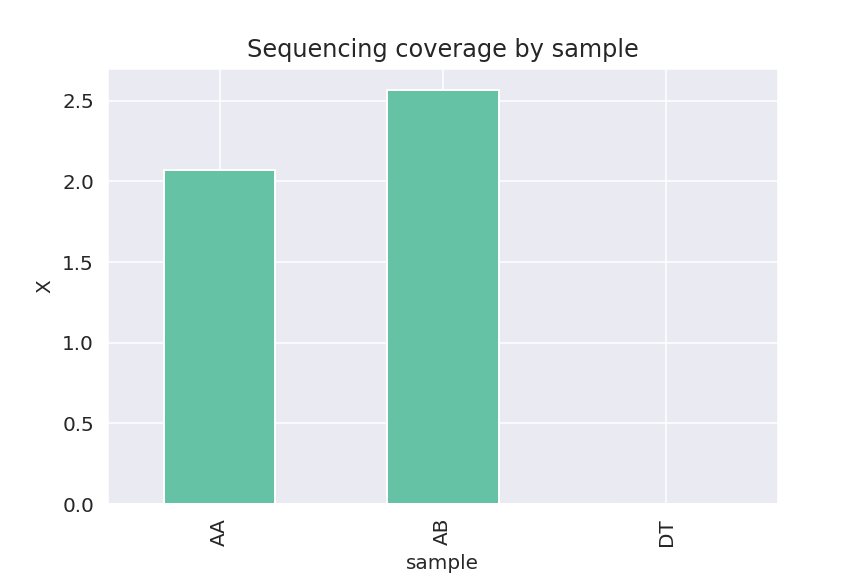
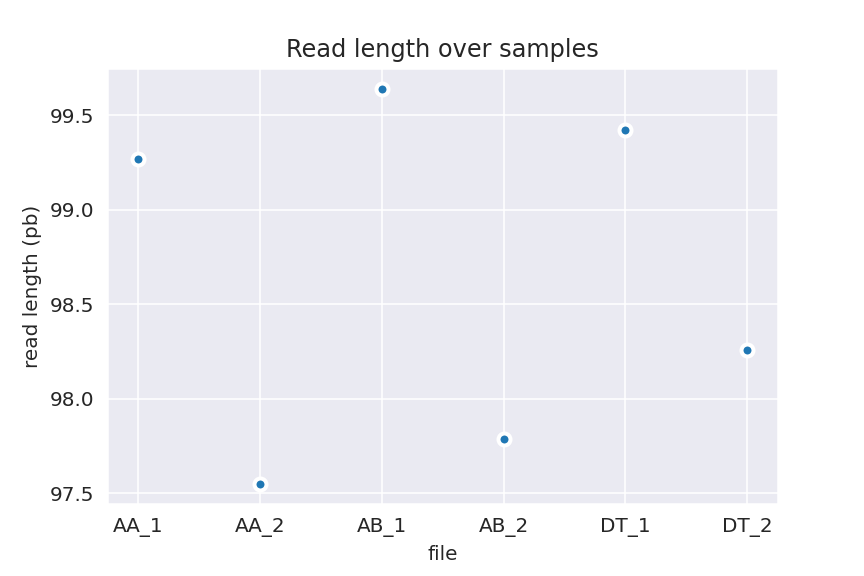
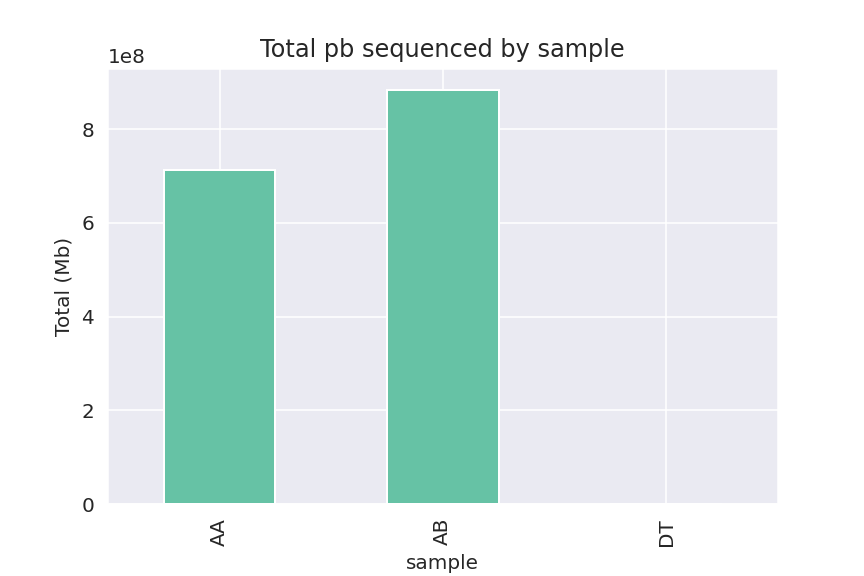
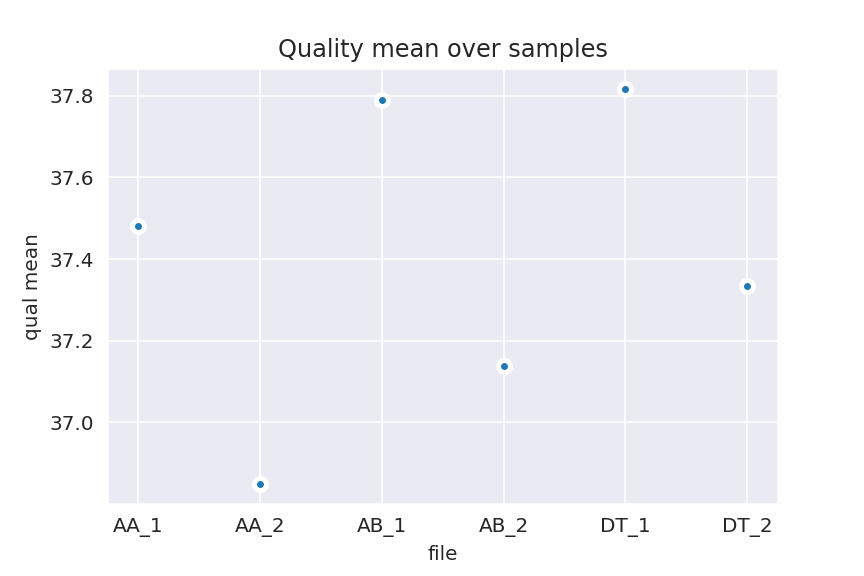
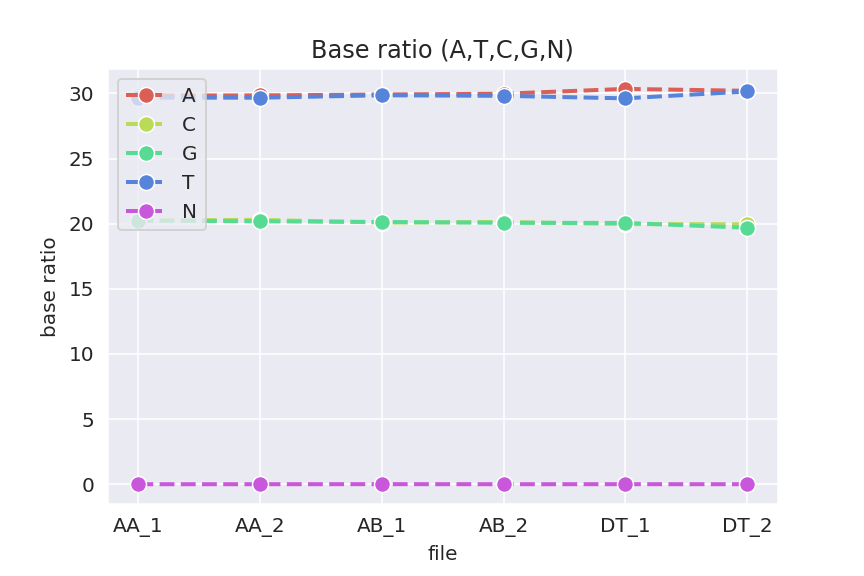

In [6]:
if df_group is None:
    text = "Analyzing Group File is required to continue !"
    display_alert(text,"danger")
    
elif not fastq_dir.value:
    text = "Fill the form with the fastq directory in the previous cell !"
    display_alert(text,"danger")

elif not output_dir:
    text = "Creating frangiPANe output directory is required to continue !"
    display_alert(text,"danger")
elif not total_genome_size:
    text = "Genome indexation and _Genome dashboard is required to continue !"
    display_alert(text,"danger")
else:
    # Creating directory
    stat_dir = os.path.join(output_dir,"00-fastq_stats")
    fastqstat_csv=os.path.join(stat_dir,"all_fastq-stats.csv")
    
    # run fastq_stats
    fastq_stats_dir(fastq_dir.value, stat_dir, df_group, logger)

    # merging all files generated by fastq_sample
    merge_fastqstat(fastqstat_csv, stat_dir,logger)

    #Raw data dashboard
    dashboard_fastq(fastqstat_csv,total_genome_size,df_group)

    bgc('LightBlue')

### <span style="color: #919395">_2 - Mapping the individuals reads against the reference genome_  <a class="anchor" id="mapping"></a></span>


#### __Mapping with `BWA mem` <a class="anchor" id="mappingbwa">__


In [7]:
if not output_dir:
    text = "Creating frangiPANe output directory is required to continue !"
    display_alert(text,"danger")
elif df_group is None:
    text = "Analyzing Group File is required to continue !"
    display_alert(text,"danger")
elif not ref_file.value or not fastq_dir.value:
    text = "Fill the form with the group file in the previous cell !"
    display_alert(text,"danger")
else:
    # Creating directory
    output_mapping_dir = os.path.join(output_dir,"01-mapping_against_reference")

    # Mapping
    fastq2bam_dir(ref_file.value, fastq_dir.value, df_group, cpu, output_mapping_dir, logger)
    
    bgc('LightBlue')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='info', css_classes=['alert', 'alert-info'], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='secondary', css_classes=['alert', 'alert-secondary...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='secondary', css_classes=['alert', 'alert-secondary...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='secondary', css_classes=['alert', 'alert-secondary...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='success', css_classes=['alert', 'alert-success']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

#### __Generating mapping stats <a class="anchor" id="mappingstat">__
    
Statistics are generated by `samtools flagstat` and they are saved into the directory _01_mapping-against_reference_ and the subdirectory _stat_

* One "flagtstat file" is generated for each bam file (http://www.htslib.org/doc/samtools-flagstat.html).

* _all_flagstat.csv_ file compiling all the stats


Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='secondary', css_classes=['alert', 'alert-secondary...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='secondary', css_classes=['alert', 'alert-secondary...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='secondary', css_classes=['alert', 'alert-secondary...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='secondary', css_classes=['alert', 'alert-secondary...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='success', css_classes=['alert', 'alert-success']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Column(background='WhiteSmoke', sizing_mode='stretch_both', width=800)
    [0] Markdown(str)
    [1] Markdown(str)
    [2] Markdown(str)
    [3] Row
        [0] Markdown(str)
        [1] DataFrame(DataFrame, width=400)
    [4] Markdown(str)
    [5] Row
        [0] Markdown(str)
        [1] DataFrame(DataFrame, width=400)
    [6] Markdown(str)
    [7] Row
        [0] Markdown(str)
        [1] DataFrame(DataFrame, width=400)
    [8] Matplotlib(Figure)
    [9] Row
        [0] MultiChoice(margin=(0, 20, 0, 0), name='Group', options=['O. barthii', ...])
        [1] MultiChoice(margin=(0, 20, 0, 0), name='Sample', options=['AA', 'AB', 'DT'])
    [10] ParamFunction(function, max_height=400, width=400)
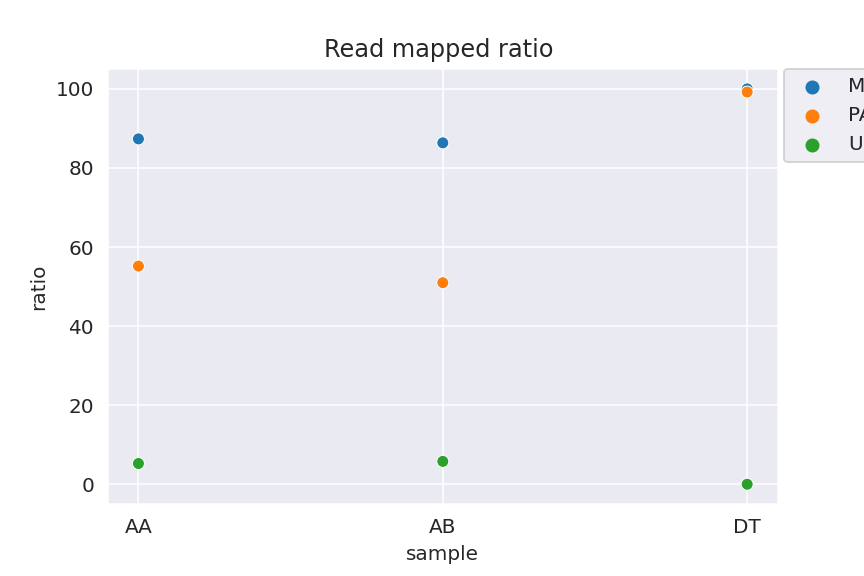

In [8]:
if not output_mapping_dir:
    text = "Previous cell ...Mapping with bwa mem... has to be executed even if the mapping were already done !"
    display_alert(text,"danger")
else :    
    stat_dir = os.path.join(output_mapping_dir,"stat")
    make_dir(stat_dir)

    logger.info(f"MAPPING STAT :")
    logger.info(f"\t\tMapping stat directory : {stat_dir}")

    for file_name in os.listdir(output_mapping_dir):
        if ".bam" in file_name:
            samtools_flagstat(os.path.join(output_mapping_dir,file_name), stat_dir,logger)

    #### __Compiling stats into a unique tabulated file__
    merge_flagstat(output_dir=stat_dir, logger=logger)
    #add_variable(file,'dash_mappingStat',1)

    ### Dashboard
    stat_file = os.path.join(stat_dir,"all_flagstat.csv")
    dashboard_flagstat(stat_file,df_group)

bgc('LightBlue')

[<img src="Images/up-arrow.png" alt="Top" width=2% align="right">](#home "Go back to the top")


### <span style="color: #919395">3 - Assembly of the individuals' reads that do not map (properly) on the reference genome <a class="anchor" id="assembly"></a></span>

#### __Extracting unmapped reads with `samtools view`__ 

Options de samtools view : -b -h -F -@ -o

In [9]:
# Creating subdirectory
output_filtered_bam = os.path.join(output_mapping_dir,"bam_F0x2")
make_dir(output_filtered_bam)

# Get unmapped reads only
bam_to_F0x2_bam_dir(output_mapping_dir,id_dict, cpu, output_filtered_bam, logger)

bgc('LightBlue')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='success', css_classes=['alert', 'alert-success']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

#### __ABYSS test to choose k-mer value__

#### _Choosing optimal k_


In [10]:
k,step,accession,length = box_config_abyss(df_group)
bgc('LightBlue')

WidgetBox(background='#E3ECF1')
    [0] Markdown(str)
    [1] Column(width=800)
        [0] Row
            [0] RangeSlider(end=92, name='K-mer length', start=24, step=4, value=(64, 68))
            [1] IntInput(end=10, name='Step', start=1, value=4)
        [1] MultiSelect(name='Accession', options=['AA', 'AB', 'DT'], value=['AA', 'AB'])
        [2] IntInput(end=10000, name='Minimal length t..., start=100, step=100, value=300)
        [3] Row
            [0] Button(button_type='primary', name='SAVE', width=100)
            [1] Button(button_type='primary', name='INIT', width=100)
        [4] Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], height=200, margin=(0, 0, 25, 0), sizing_mode='stretch_width')

##### Execute Abyss with several k

TODO : ADD TEST TO REMOVE ADDITIONAL SAMPLES FROM PREVIOUS RUNS + test if k filled

In [11]:
output_assembly_dir = os.path.join(output_dir,"02-assembly_unmapped_reads")
make_dir(output_assembly_dir)
    
output_assembly_test= os.path.join(output_assembly_dir,"01-choosing_k")
make_dir(output_assembly_test)

output_assembly_fasta = os.path.join(output_assembly_test,"fasta")
make_dir(output_assembly_fasta)

if not accession.value:
    text = "Fill the form in the previous cell, select one or several accessions and save your results !"
    display_alert(text,"danger")
else:
    kmin=int(k.value[0])
    kmax=int(k.value[1])+1
    st=step.value
    threshold =  length.value

    for k in range(kmin, kmax, step.value) :
        for id in accession.value : ### INDIVIDUS TEST
            abyss_pe(project_name.value, id, k, output_filtered_bam, output_assembly_test, logger) 
            filter_fastq_threshold(output_assembly_test + "/" + id + "_k" + str(k) + "/" + project_name.value+ "_" + id + "_" + str(k) + "-contigs.fa",
                               output_assembly_fasta + "/" + id + "_k" + str(k) + "_thr" + str(threshold) + "-contigs.fasta", threshold)

    text = f"""
### Extracting fasta sequences and filtering on length > { threshold } bp 
<hr>

* BAM INPUT DIR : {output_filtered_bam}
* ABYSS DIR : {output_assembly_test}
* FASTA DIR : {output_assembly_fasta}
"""

display_alert(text, "success")
bgc('LightBlue')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='success', css_classes=['alert', 'alert-success']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

#### _Stats and plots of abyss test_


Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='secondary', css_classes=['alert', 'alert-secondary...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='success', css_classes=['alert', 'alert-success']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='secondary', css_classes=['alert', 'alert-secondary...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='success', css_classes=['alert', 'alert-success']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Column(background='WhiteSmoke', sizing_mode='stretch_both', width=800)
    [0] Markdown(str)
    [1] Row
        [0] Markdown(str)
    [2] Row(width=800)
        [0] Matplotlib(Figure)
    [3] Row
        [0] Markdown(str)
    [4] Row(width=800)
        [0] Matplotlib(Figure)
    [5] Row
        [0] Markdown(str)
    [6] Row(width=800)
        [0] Matplotlib(Figure)
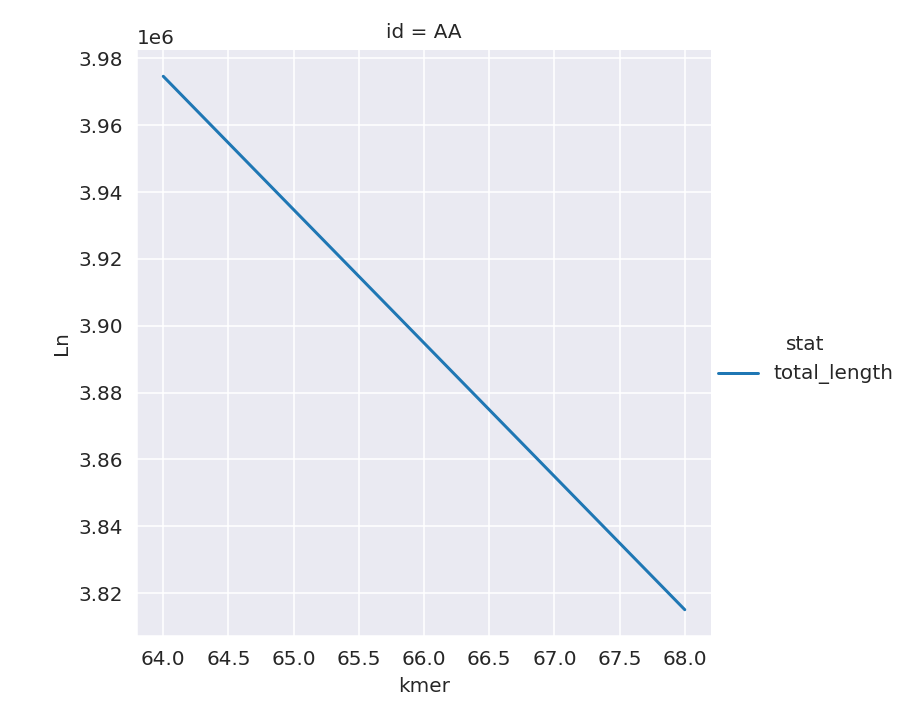
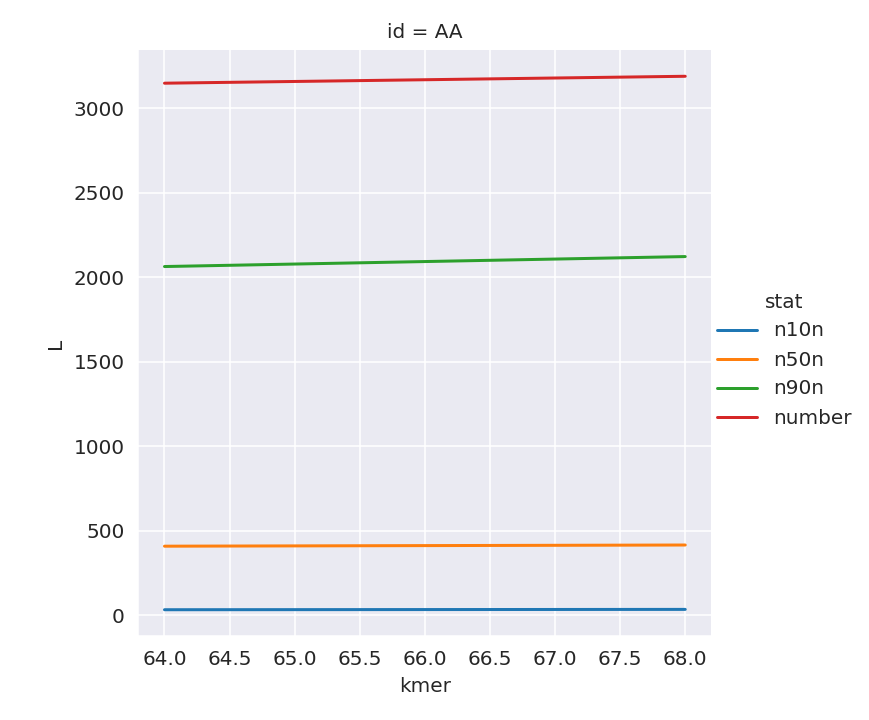
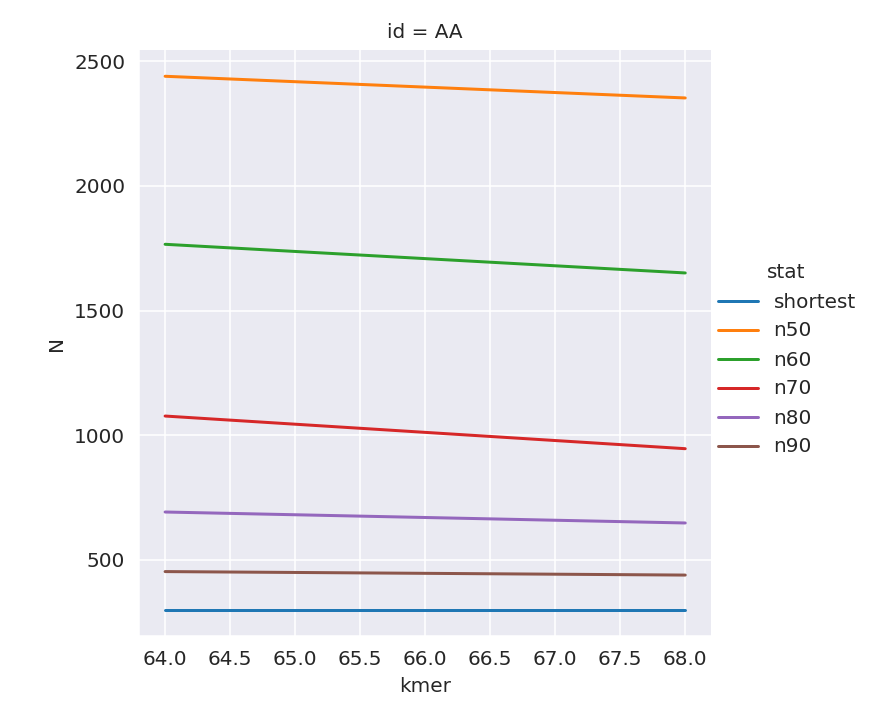

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [12]:
#  create stats file
output_assembly_testplots = os.path.join(output_assembly_test,"plots") 
make_dir(output_assembly_testplots)

stat_len, stats_N_hide, stats_N, stats_L_hide, stats_L, stats_gap, stats = def_stats()
create_stats_files(stats, output_assembly_testplots)

for k in range(kmin, kmax, step.value) :
    for id in accession.value :
        fill_stats_files(output_assembly_fasta, id, k, output_assembly_testplots, threshold, logger)
        
dashboard_ab(stat_len,stats_N,stats_L,output_assembly_testplots)

bgc('LightBlue')

#### __Assembly step 2 : assembly with the final k value__

### Running ABySS for each individual


In [13]:
k2 = box_config_abyss2()
bgc('LightBlue')

WidgetBox(background='#E3ECF1')
    [0] Markdown(str)
    [1] Column(width=800)
        [0] IntInput(end=92, name='K-mer length', start=24, value=64)
        [1] Row
            [0] Button(button_type='primary', name='SAVE', width=100)
            [1] Button(button_type='primary', name='INIT', width=100)
        [2] Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], height=200, margin=(0, 0, 25, 0), sizing_mode='stretch_width')

check group -> debug DT

In [14]:
import glob

output_assembly_ctgs = os.path.join(output_assembly_dir,"02-final_abyss") 
make_dir(output_assembly_ctgs)

output_assembly_ffasta = os.path.join(output_assembly_ctgs,"fasta/")
make_dir(output_assembly_ffasta)
         
kfinal = int(k2.value) 

#for id in df_group :
for index, row in df_group.iterrows() :

    id = row['sample']
    id_folder =  id + "_k" + str(kfinal)      
         
    if index==2 :
        continue
        
    if id in accession.value :
        
        ln_dir=os.path.join(output_assembly_ctgs,id_folder)
        if not os.path.exists(ln_dir):
            os.symlink(os.path.join(output_assembly_test,id_folder),  os.path.join(ln_dir))
        else:
            at = "warning"
            text = f"""### {at }
<hr>
Symbolic Link of this directory {ln_dir} already existed"""

            display_alert(text,at)
        
        files = glob.iglob(os.path.join(output_assembly_fasta, f"*{id_folder}*.fasta"))
        for file in files:
            #print(file)
            if os.path.isfile(file):
                shutil.copy(file, output_assembly_ffasta)
                os.remove(file)
    else : 
        abyss_pe(project_name.value, id, kfinal, output_filtered_bam, output_assembly_ctgs, logger) 
        filter_fastq_threshold(output_assembly_ctgs + "/" + id_folder + "/" + project_name.value+ "_" + id + "_" + str(kfinal) + "-contigs.fa",
                               output_assembly_ffasta + "/" + id_folder + "_thr" + str(threshold) + "-contigs.fasta", threshold)
        
text = f"""
    ### Assembly with abyss and fixed khmer
    
    <hr>

    * BAM DIR : {output_filtered_bam}
    * ABYSS DIR : {output_assembly_ctgs}
    """

display_alert(text, "success")

bgc('LightBlue')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='success', css_classes=['alert', 'alert-success']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

`TODO : PUT TABLE SYNTHESE`

[<img src="Images/up-arrow.png" alt="Top" width=2% align="right">](#home "Go back to the top")
    
### <span style="color: #919395"> 4 - Removing contamination<a class="anchor" id="contamination"></a></span>

#### __VecScreen__

[BDD UniVec_Core](https://ftp.ncbi.nlm.nih.gov/pub/UniVec/UniVec_Core) + makeblastdb -in UniVec_Core -dbtype nucl
VecScreen parameters :
   * -i  Query File
   * -o  Output File
   * -d  Database
   * -f  Output format [3 = Text list, no alignments]
   
sudo apt install ncbi-tools-bin


In [15]:
print(vec_file.value)

/home/christine/Documents/These/frangiPANeGIT/rice/bank/UniVec_Core


In [30]:
def index_blast(db_file):
    
    suffixes = [".nhr",".nin",".nsq"]
    logger.info(f"CHECKING BLAST INDEX FOR VECTOR BANK :")
    logger.info(f"\t\tFasta : {db_file}")
    text=f"Searching index files for reference file {db_file}"
    display_alert(text, "info")
    cpt_test_files = 0
    
    for suffix in suffixes:
        tested_file = db_file + suffix
       
        if not path.exists(tested_file):
            text=f"Indexation in progress with makeblastdb..."
            display_alert(text, "secondary")
            cmd = f"makeblastdb -in {db_file} -dbtype 'nucl' -blastdb_version 4"
            logger.info(f"\t\tmakeblastdb cmd : {cmd}")
            process = subprocess.run(cmd, shell=True, capture_output=True, text=True)

            if process.returncode:
                log = f'FAILED EXECUTION : {cmd}\n{process.stdout}\n{process.stderr}'
                raise ValueError(log)
            else:
                #display(msg_button(f"SUCCESSFUL INDEXATION: {cmd}", 'green', 'classic'))
                logger.info(f"\t\tLog : {process.stdout + process.stderr}\n")
            break
        else :
            cpt_test_files += 1 # Avoid to get 1 notification per suffix tested

    if cpt_test_files == len(suffixes) :
        text = f"Index files already available ({db_file}).... Skip Indexation Step"
        at='warning'
    else:
        at='success'
        text = f"""
### indexation with blast db index Successful 

<hr>

* BANK : {db_file}
* COMMAND :  {cmd}
* Log blast into log file
"""
    display_alert(text, at)
    
index_blast(vec_file.value)

Alert(str, alert_type='info', css_classes=['alert', 'alert-info'], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='secondary', css_classes=['alert', 'alert-secondary...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='success', css_classes=['alert', 'alert-success']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

In [31]:
def run_vecscreen(fasta_dir, id, k, threshold, output_dir,bank):
    
    from Bio import SeqIO
    
    # print("--- id : " + id)
    tag = id + "_k" + str(k) + "_thr" + str(threshold) 
    fasta_file = os.path.join(fasta_dir, tag  + "-contigs.fasta")
    output_file = os.path.join(output_dir, tag + '_vecscreen.fasta')
    
    nb_seq, nb_seq_no_hits, nb_seq_suspicious = 0, 0, 0
    text=f"VecScreen for {id} (k = {k}) in progress ..."
    display_alert(text, "secondary")
    
    with open(output_file, "w") as o :
    
        for seq in SeqIO.parse(fasta_file, "fasta"):
            # Vecscreen only works with fasta file, not sequence
            tmp_file = output_dir + "tmp.fasta"

            with open(tmp_file, "w") as tmp :
                tmp.write('>' + str(seq.description) + '\n')
                tmp.write(format_60(str(seq.seq)) + '\n')
            
            cmd = f'vecscreen -d {bank} -i {tmp_file} -f 3'
            process = subprocess.run(cmd, shell=True, capture_output=True, text=True)
            logger.info(f"\t\t\tvecscreen cmd : {cmd}")
                   
            if process.returncode:
                text = f"Failed execution ({cmd}).... see log file, resolve the problem and try again"
                at = 'danger'
            else:
                at = 'success'
                text = f"vecscreen executed successfully ({os.path.basename(tmp_file)})"

                if 'No hits found' in process.stdout :
                    o.write('>' + str(seq.description) + '\n')
                    o.write(format_60(str(seq.seq))+ '\n')
                    nb_seq += 1
                    nb_seq_no_hits += 1
                else :
                # print(process.stdout)
                # print("Hits : >" + str(seq.description))
                    nb_seq_suspicious += 1
                    bounds = []
                    for line in process.stdout.split("\n") :
                        if len(line) > 0 :
                            if line[0].isnumeric() :
                                for value in line.split('\t') :
                                    bounds.append(int(value))
                    min_seq = 0
                    max_seq = len(seq)
                    min_bounds = min(bounds)
                    max_bounds = max(bounds)
                    if min_bounds == min_seq + 1 :
                        min_seq = max_bounds
                        new_length = max_seq - max_bounds
                        if new_length >= threshold :
                            header_fields = str(seq.description).split()
                            o.write('>' + header_fields[0] + " " + str(new_length) + " " + " ".join(header_fields[2:]) + '\n')
                            o.write(format_60(str(seq.seq[min_seq:max_seq])) + '\n')
                            nb_seq += 1
                    elif max_bounds == max_seq :
                        max_seq = min_bounds
                        new_length = max_seq
                        if new_length >= threshold :
                            header_fields = str(seq.description).split()
                            o.write('>' + header_fields[0] + " " + str(new_length) + " " + " ".join(header_fields[2:]) + '\n')
                            o.write(format_60(str(seq.seq[min_seq:max_seq])) + '\n')
                            nb_seq += 1
                    else :
                        print("Warning (seq : " + str(seq.description) + ") : the detected contamination appears to be in the middle of the contig !")
                cmd = f'rm {tmp_file}'
                #process = f'subprocess.run(cmd, shell=True, capture_output=True, text=True)'
                
    text = f"""
    ### VecScreen
    <hr>
    * NO HITS : {nb_seq_no_hits}
    * SUSPICIOUS : {nb_seq_suspicious}
    * KEPT : {nb_seq}
    """
    display_alert(text, "success")

In [32]:
output_contamination = os.path.join(output_dir,"03-check_contamination")
make_dir(output_contamination)

output_vecscreen = os.path.join(output_contamination,"vecscreen")
make_dir(output_vecscreen)
    
for index, row in df_group.iterrows() :
    id = row['sample']
    run_vecscreen(fasta_dir=output_assembly_ffasta,
                  id=id,
                  k=kfinal,
                  threshold=threshold,
                  output_dir=output_vecscreen,
                  bank=vec_file.value)
bgc('LightBlue')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='secondary', css_classes=['alert', 'alert-secondary...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='success', css_classes=['alert', 'alert-success']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='secondary', css_classes=['alert', 'alert-secondary...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='success', css_classes=['alert', 'alert-success']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='secondary', css_classes=['alert', 'alert-secondary...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

FileNotFoundError: [Errno 2] No such file or directory: '/home/christine/Documents/These/frangiPANeGIT2/frangiPANe_PANRice/02-assembly_unmapped_reads/02-final_abyss/fasta/DT_k64_thr300-contigs.fasta'

#### __BLASTn__

[<img src="Images/up-arrow.png" alt="Top" width=2% align="right">](#home "Go back to the top")
    
### <span style="color: #919395"> 5 - Reducing Sequence Redundancy<a class="anchor" id="redundancy"></a></span>

frangiPANe uses CD-HIT to cluster sequences and to reduce sequence redundancy (inter and intra-species).

`pb count seq cluster`

`msg dashboard, stat on progress`


#### __Merge all contigs__


In [56]:
### create clustering directory
output_clustering_dir = os.path.join(output_dir,"03-clustering")
make_dir(output_clustering_dir)

copy_cluster(output_assembly_ctgs,output_clustering_dir)
### ADD logger

merged_contigs = output_clustering_dir+project_name.value+"_allContigs.fa"    
merging_cluster(output_clustering_dir,merged_contigs)

bgc('LightBlue')

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='secondary', css_classes=['alert', 'alert-secondary...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='info', css_classes=['alert', 'alert-info'], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='secondary', css_classes=['alert', 'alert-secondary...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='success', css_classes=['alert', 'alert-success']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

In [ ]:
STAT

Alert(str, alert_type='secondary', css_classes=['alert', 'alert-secondary...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='success', css_classes=['alert', 'alert-success']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Column(background='WhiteSmoke', sizing_mode='stretch_both', width=800)
    [0] Markdown(str)
    [1] Markdown(str)
    [2] Row
        [0] Markdown(str)
        [1] Markdown(str)
    [3] Matplotlib(Figure)
    [4] Matplotlib(Figure)
    [5] Matplotlib(Figure)
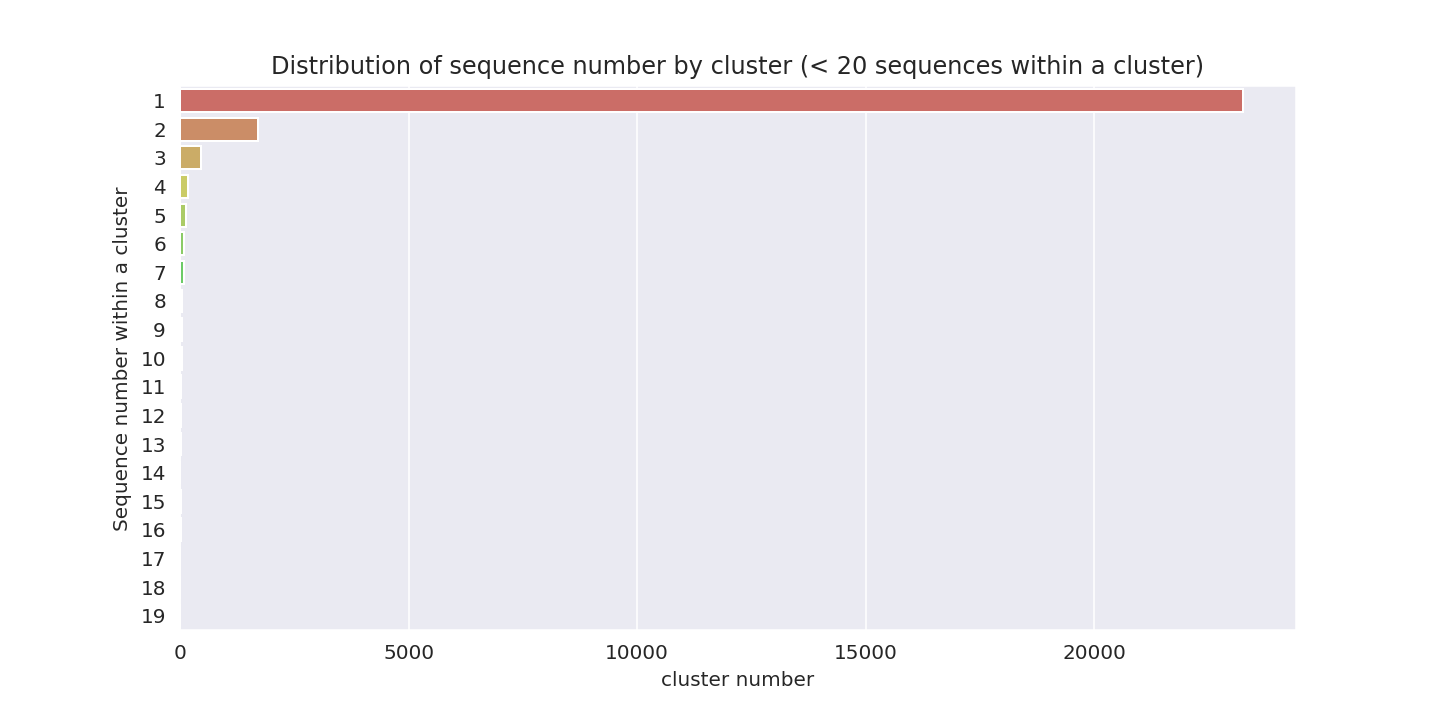
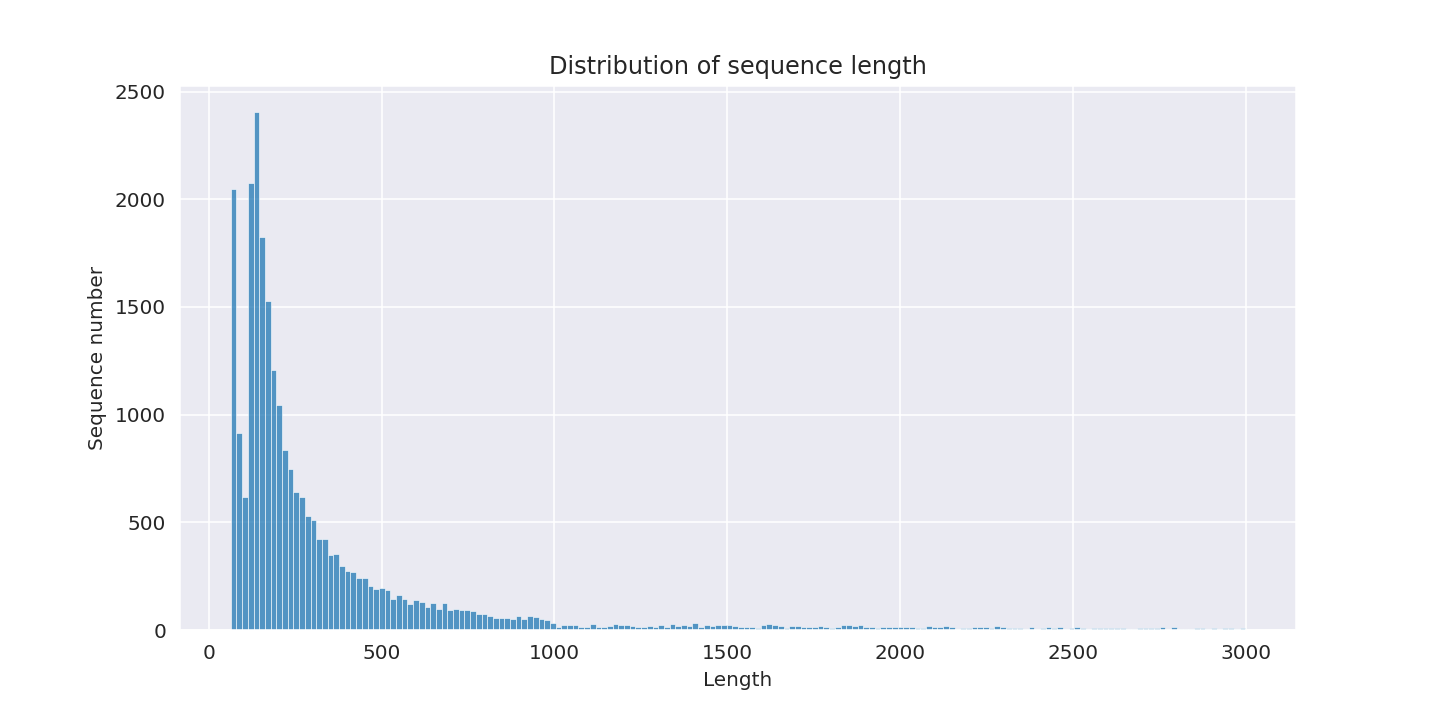
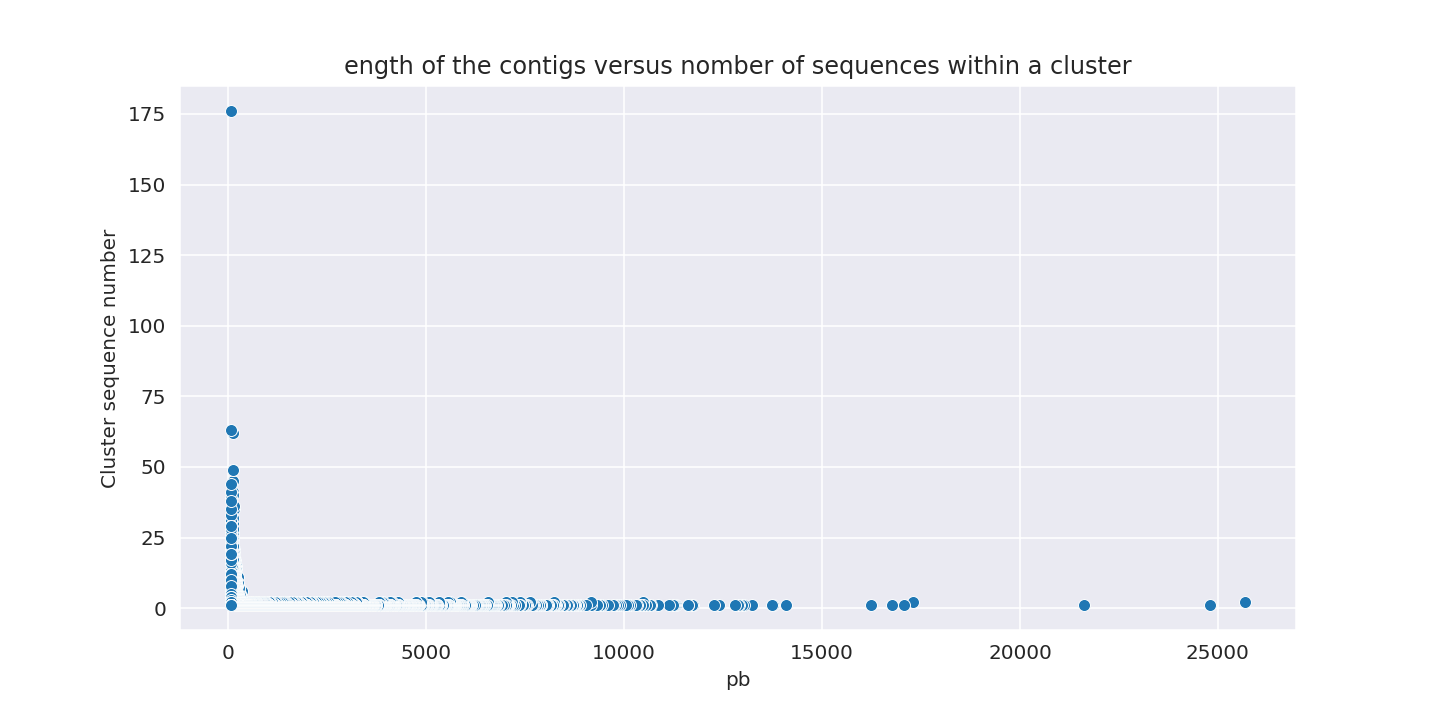

In [57]:

# TODO CD : CHECK NB SEQUENCE OK ET PRINT DANS LE MSG + add logger

# Run clustering
cdhit_fasta = output_clustering_dir+project_name.value+"_clusters.cdhit"  
cdhit(merged_contigs,0.8,0.95, cdhit_fasta, logger)

# Analysing
cdhit_cluster = cdhit_fasta + ".clstr"
cdhit_csv=cdhit_fasta + ".csv"
df_cdhit=parse_cdhit(cdhit_cluster, df_group, cdhit_csv)

#Dashboard
dashboard_cdhit(df_cdhit)

bgc('LightBlue')

[<img src="Images/up-arrow.png" alt="Top" width=2% align="right">](#home "Go back to the top")
    
### <span style="color: #919395"> 6 - Anchoring Clusters on Reference Genome<a class="anchor" id="anchoring"></a></span>

#### __Generating panreference__

---


In [58]:
### create  directory
output_panref_dir = output_dir + "/04-panreference/"
make_dir(output_panref_dir)

panref_fasta = output_panref_dir + project_name.value+"_panref.fasta"
filenames = [ref_file.value, cdhit_fasta]

with open(panref_fasta, 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                outfile.write(line)

display_alert(f"Panreference file successfully created : {panref_fasta}", "success")

index_reference_genome(panref_fasta, logger)
#total_genome_size=dashboard_genome(panref_fasta)

bgc('LightBlue')

Alert(str, alert_type='success', css_classes=['alert', 'alert-success']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='success', css_classes=['alert', 'alert-success']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='info', css_classes=['alert', 'alert-info'], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='secondary', css_classes=['alert', 'alert-secondary...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='success', css_classes=['alert', 'alert-success']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

#### __Mapping against panreference__


In [59]:
bgc('LightBlue')

output_panrefmapping_dir = output_panref_dir + "/mapping/"
fastq2bam_dir(panref_fasta, fastq_dir.value, df_group, cpu, output_panrefmapping_dir, logger)

stat2_dir = output_panref_dir + "/mapping_stat/"
make_dir(stat2_dir)

logger.info(f"MAPPING STAT :")
logger.info(f"\t\tMapping stat directory : {stat_dir}")

for file_name in os.listdir(output_panrefmapping_dir):
    if ".bam" in file_name:
        samtools_index(os.path.join(output_panrefmapping_dir,file_name),logger)


Alert(str, alert_type='success', css_classes=['alert', 'alert-success']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='info', css_classes=['alert', 'alert-info'], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='secondary', css_classes=['alert', 'alert-secondary...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='success', css_classes=['alert', 'alert-success']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='secondary', css_classes=['alert', 'alert-secondary...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='success', css_classes=['alert', 'alert-success']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='secondary', css_classes=['alert', 'alert-secondary...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='success', css_classes=['alert', 'alert-success']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='secondary', css_classes=['alert', 'alert-secondary...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='success', css_classes=['alert', 'alert-success']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='secondary', css_classes=['alert', 'alert-secondary...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='success', css_classes=['alert', 'alert-success']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='secondary', css_classes=['alert', 'alert-secondary...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='success', css_classes=['alert', 'alert-success']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='success', css_classes=['alert', 'alert-success']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='success', css_classes=['alert', 'alert-success']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='secondary', css_classes=['alert', 'alert-secondary...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='success', css_classes=['alert', 'alert-success']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='secondary', css_classes=['alert', 'alert-secondary...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='success', css_classes=['alert', 'alert-success']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='secondary', css_classes=['alert', 'alert-secondary...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='success', css_classes=['alert', 'alert-success']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

#### __Anchoring contigs on reference genome__

#### __Panreference dashboard__

In [61]:


panrefposi_dir = output_panref_dir + "/placement/"
make_dir(panrefposi_dir)

panrefposi_file = panrefposi_dir + "ctgs_on_ref.csv"

#logger.info(f"MAPPING STAT :")
#logger.info(f"\t\tMapping stat directory : {stat_dir}")

for file_name in os.listdir(output_panrefmapping_dir):
    if ".bam" in file_name and not os.pa:
        samtools_index(os.path.join(output_panrefmapping_dir,file_name),logger)

text=f"Anchoring indexing..."
display_alert(text, "secondary")

cmd = f'tools/parseBamv7.py -b {output_panrefmapping_dir} -d 15 -o {panrefposi_file}'
process = subprocess.run(cmd, shell=True, capture_output=True, text=True)
logger.info(f"\t\t\placement cmd : {cmd}")

if process.returncode:
    text = f"Failed execution.... see log file, resolve the problem and try again"
    at = 'danger'
else:
    at = 'success'
    text = f"script executed successfully)"
logger.info(f"\t\t\tLog : {process.stdout + process.stderr}")
display_alert(text, at)
    

Alert(str, alert_type='warning', css_classes=['alert', 'alert-warning']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='secondary', css_classes=['alert', 'alert-secondary...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='danger', css_classes=['alert', 'alert-danger'], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='secondary', css_classes=['alert', 'alert-secondary...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='success', css_classes=['alert', 'alert-success']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='secondary', css_classes=['alert', 'alert-secondary...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='danger', css_classes=['alert', 'alert-danger'], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='secondary', css_classes=['alert', 'alert-secondary...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='success', css_classes=['alert', 'alert-success']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='secondary', css_classes=['alert', 'alert-secondary...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='danger', css_classes=['alert', 'alert-danger'], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='secondary', css_classes=['alert', 'alert-secondary...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='success', css_classes=['alert', 'alert-success']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='secondary', css_classes=['alert', 'alert-secondary...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')

Alert(str, alert_type='success', css_classes=['alert', 'alert-success']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')